# Overview

This notebook is the result of a quick exploration of the distances reported in the Uber driver data.

Some libraries need to be installed in addition to those specified in the README.md since this notebook is somewhat independent.

In [ ]:
import os

import numpy as np
import requests
import seaborn as sns
import statsmodels.formula.api as smf
from ipynb.fs.full.Pipeline import load_lifetime_trips, load_on_off
from sklearn.preprocessing import LabelEncoder

from src.utils import *

# To retrieve the routing distance from the begin GPS coordinate to the end one, we use OSRM.
The following steps are required:
1. Install [docker](https://docs.docker.com/get-docker/)
2. Download OSM map file(s) [here](http://download.geofabrik.de/europe.html)
   - if many map files are downloaded, they need to be merged using [this tool](https://github.com/osmcode/osmium-tool) that can be installed following [these instructions](https://github.com/osmcode/osmium-tool)
3. Install [OSRM-backend](https://github.com/Project-OSRM/osrm-backend)
4. Start a local server using your (potentially merged) map file following [these instructions](https://github.com/Project-OSRM/osrm-backend#using-docker)
5. Run the two next cells

In [ ]:
def get_osrm_distance_km(row: pd.Series) -> float:
    r = requests.get(f'http://127.0.0.1:5000/route/v1/car/{row.begin_lng},{row.begin_lat};{row.end_lng},{row.end_lat}')
    if r.status_code != 200:
        return np.nan
    res = r.json()
    return res['routes'][0]['distance'] / 1000

In [ ]:
oo = pd.DataFrame()
for filename in os.listdir(Path(os.getcwd()) / 'data'):
    if 'SAR' in filename and filename.endswith('zip') and 'old' not in filename:
        with ZipFile(Path(os.getcwd()) / 'data' / filename) as zf:
            oo = pd.concat([oo, load_on_off(zf, timezone='Europe/Zurich')])
oo.reset_index(drop=True, inplace=True)
oo['osrm_distance_km'] = oo.swifter.apply(get_osrm_distance_km, axis=1)
oo['driver'] = LabelEncoder().fit_transform(oo['file'])
oo['birdeye_distance_km'] = oo['birdeye_distance_km_x_1.5'] / 1.5
oo.drop(columns=['birdeye_distance_km_x_15', 'file'], inplace=True)
oo.dropna(inplace=True)
oo.reset_index(drop=True, inplace=True)
oo.to_csv('data/results/SAR-on-off-distances.csv', index=False)

In [ ]:
oo = pd.read_csv('data/results/SAR-on-off-distances.csv')

We plot the data and see some outliers for big distances, i.e. points below the y=x line, so we drop them.

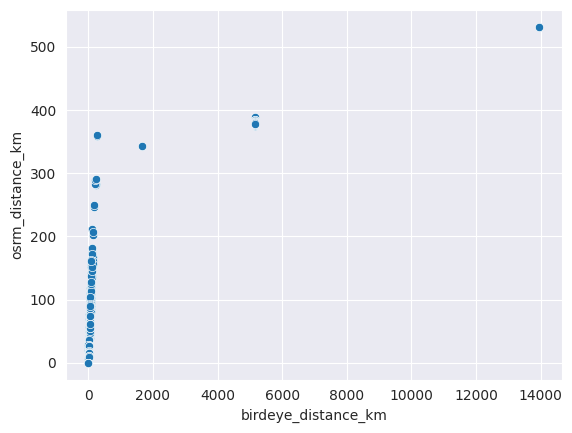

In [5]:
sns.scatterplot(oo, x='birdeye_distance_km', y='osrm_distance_km');

In [6]:
df = oo[(oo.birdeye_distance_km < 150) & oo.status.isin(['P1', 'P2', 'P3'])]

Now all points lie above y = x

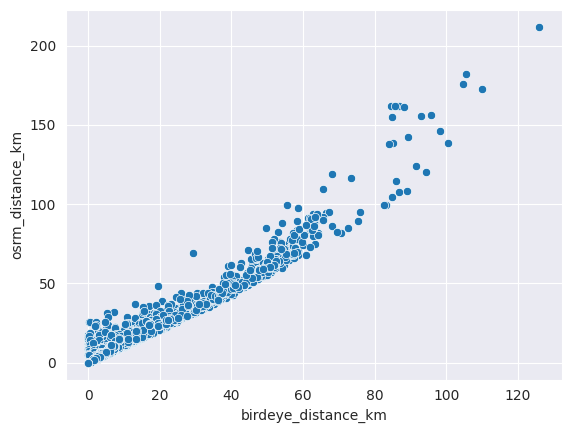

In [7]:
sns.scatterplot(df, x='birdeye_distance_km', y='osrm_distance_km');

Using `statsmodel`, we perform a couple linear regression of the distance reported by OSRM based on the bird-eye distance and the status of the driver.

The formula we use in the first one is equivalent to `osrm_distance_km ~ birdeye_distance_km*status`, but the two subtractions force the coefficients in $y = a_s x + b_s$ to be self-contained (i.e. there is no global $a$ and $b$).

`status[s]` corresponds to the intercepts $b_s$, while `birdeye_distance_km:status[s]` corresponds to the slopes $a_s$.

In [14]:
res = smf.ols(data=df, formula='osrm_distance_km ~ birdeye_distance_km*status - 1 - birdeye_distance_km').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       osrm_distance_km   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 1.605e+06
Date:                Fri, 30 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:51:30   Log-Likelihood:            -3.4338e+05
No. Observations:              282686   AIC:                         6.868e+05
Df Residuals:                  282680   BIC:                         6.868e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
status[P1]                         0.1776      0.003     68.718      0.000       0.172       0.183
status[P2]                         0.2323      0.003     70.249      0.000       0.226       0.239
status[P3]                         0.3564      0.004     87.725      0.000       0.348       0.364
birdeye_distance_km:status[P1]     1.2461      0.001   1852.965      0.000       1.245       1.247
birdeye_distance_km:status[P2]     1.2648      0.002    536.122      0.000       1.260       1.269
birdeye_distance_km:status[P3]     1.2583      0.001   1811.015      0.000       1.257       1.260
==============================================================================
Omnibus:                   527223.766   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4483730405.193
Skew:                          13.475   Prob(JB):                         0.00
Kurtosis:                     619.394   Cond. No.                         7.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Similar regression to the previous one but doesn't contain intercepts (i.e. $y = a_s x$)

In [9]:
res = smf.ols(data=df, formula='osrm_distance_km ~ birdeye_distance_km:status - 1').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       osrm_distance_km   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          3.436e+06
Date:                Fri, 30 Dec 2022   Prob (F-statistic):                        0.00
Time:                        17:50:00   Log-Likelihood:                     -3.5180e+05
No. Observations:              282686   AIC:                                  7.036e+05
Df Residuals:                  282683   BIC:                                  7.036e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
birdeye_distance_km:status[P1]     1.2649      0.001   1997.810      0.000       1.264       1.266
birdeye_distance_km:status[P2]     1.3613      0.002    688.820      0.000       1.357       1.365
birdeye_distance_km:status[P3]     1.2986      0.001   2416.855      0.000       1.298       1.300
==============================================================================
Omnibus:                   475886.500   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2683401945.774
Skew:                          10.769   Prob(JB):                         0.00
Kurtosis:                     479.819   Cond. No.                         3.68
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This next regression is independent of driver status

In [10]:
res = smf.ols(data=df, formula='osrm_distance_km ~ birdeye_distance_km - 1').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       osrm_distance_km   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          1.019e+07
Date:                Fri, 30 Dec 2022   Prob (F-statistic):                        0.00
Time:                        17:50:31   Log-Likelihood:                     -3.5334e+05
No. Observations:              282686   AIC:                                  7.067e+05
Df Residuals:                  282685   BIC:                                  7.067e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
birdeye_distance_km     1.2876      0.000   3192.545      0.000       1.287       1.288
==============================================================================
Omnibus:                   469275.810   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2519113122.938
Skew:                          10.450   Prob(JB):                         0.00
Kurtosis:                     464.991   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This last regression is also independent of driver status but is different for each driver

In [11]:
res = smf.ols(data=df, formula='osrm_distance_km ~ birdeye_distance_km:C(driver) - 1').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       osrm_distance_km   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          2.056e+06
Date:                Fri, 30 Dec 2022   Prob (F-statistic):                        0.00
Time:                        17:50:33   Log-Likelihood:                     -3.5218e+05
No. Observations:              282686   AIC:                                  7.044e+05
Df Residuals:                  282681   BIC:                                  7.044e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
birdeye_distance_km:C(driver)[0]     1.2861      0.001    970.109      0.000       1.284       1.289
birdeye_distance_km:C(driver)[1]     1.2761      0.001   1884.817      0.000       1.275       1.277
birdeye_distance_km:C(driver)[2]     1.3450      0.001   1051.073      0.000       1.342       1.348
birdeye_distance_km:C(driver)[3]     1.2859      0.001   1610.436      0.000       1.284       1.287
birdeye_distance_km:C(driver)[4]     1.2828      0.001   1444.622      0.000       1.281       1.285
==============================================================================
Omnibus:                   466821.773   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2400934772.754
Skew:                          10.343   Prob(JB):                         0.00
Kurtosis:                     454.011   Cond. No.                         1.96
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

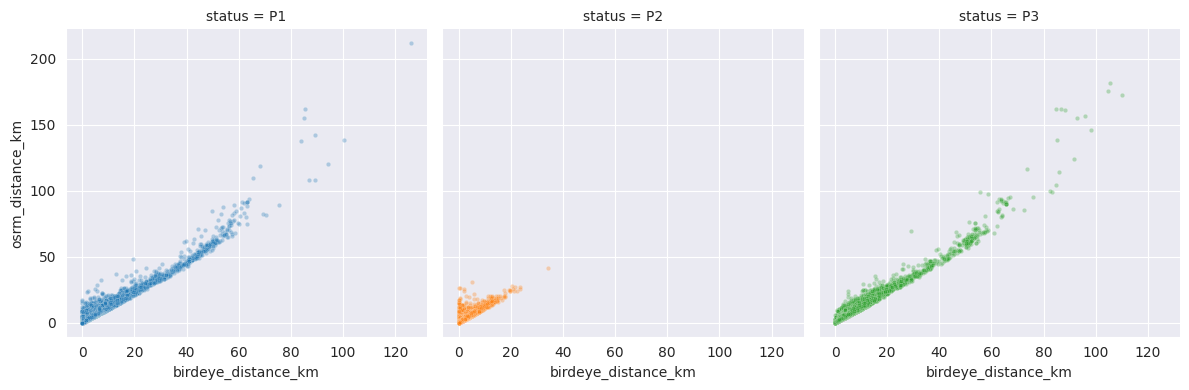

In [12]:
g = sns.FacetGrid(df, col='status', hue='status', height=4, aspect=1)
g.map_dataframe(sns.scatterplot, x='birdeye_distance_km', y='osrm_distance_km', s=10, alpha=0.3);

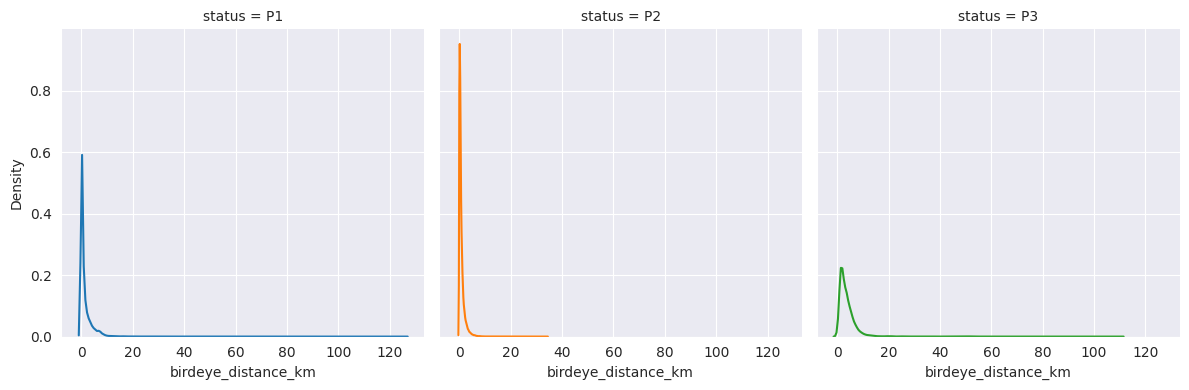

In [13]:
g = sns.FacetGrid(df, col='status', hue='status', height=4, aspect=1)
g.map_dataframe(sns.kdeplot, x='birdeye_distance_km');

# Next goal

The ideal thing would be to be able to compare the distance provided by Uber in the lifetime trips files with the ones we retrieved using OSRM.

To do that, it is necessary to pair information from the Online-Offline file with that of Lifetime-Trips.
This is not an easy tasks as the given periods do not match even though they seemingly should.
For instance, we expect that a row in Lifetime Trips with a `begintrip` of t0 and `dropoff` timestamp of t1 should have a corresponding entry in the Online-Offline file with status P3 (or ontrip) and t0 as begin and t1 as end timestamps.